In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools


# Set paths to input and output data
INPUT_DIR = './soundRaw/'
OUTPUT_DIR = './working/'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in range(8):
    print(parent_list[i])

1 (1).wav
1 (10).wav
1 (100).wav
1 (101).wav
1 (102).wav
1 (103).wav
1 (104).wav
1 (105).wav


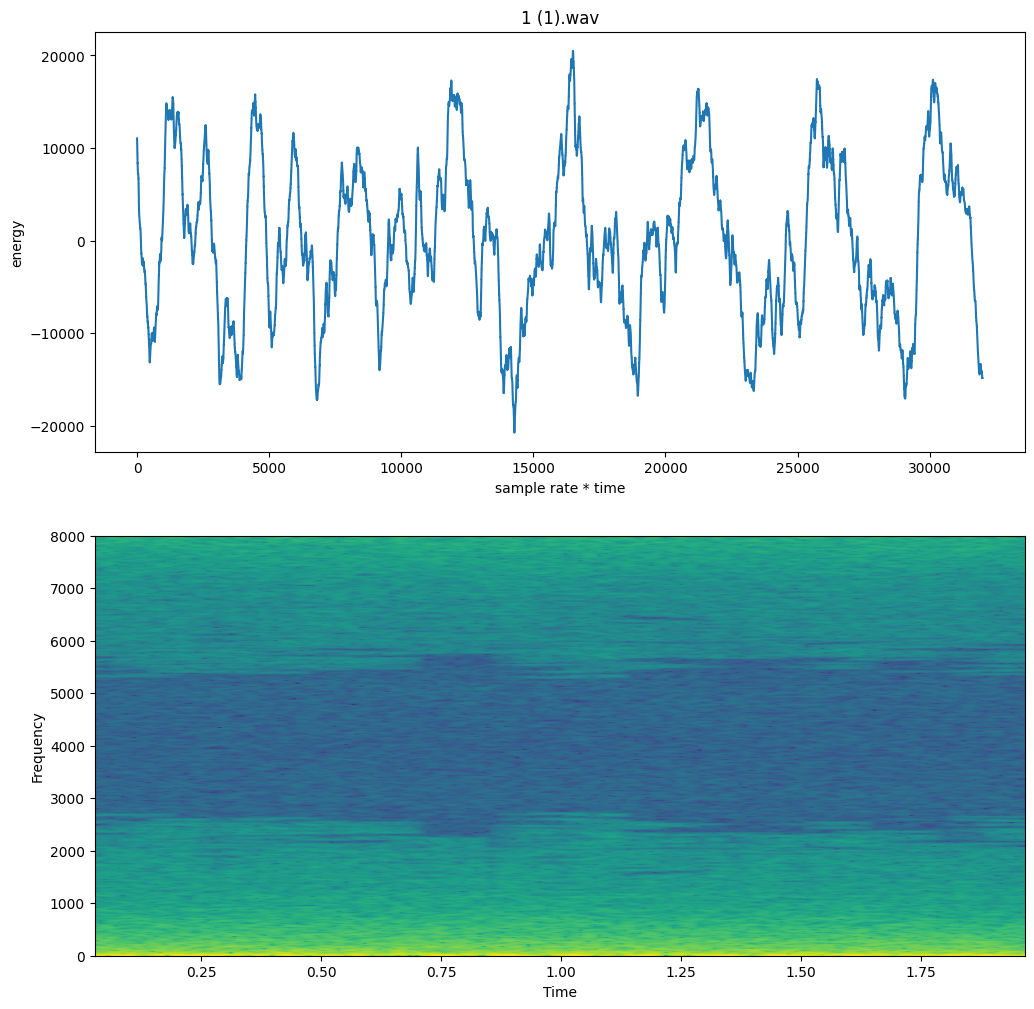

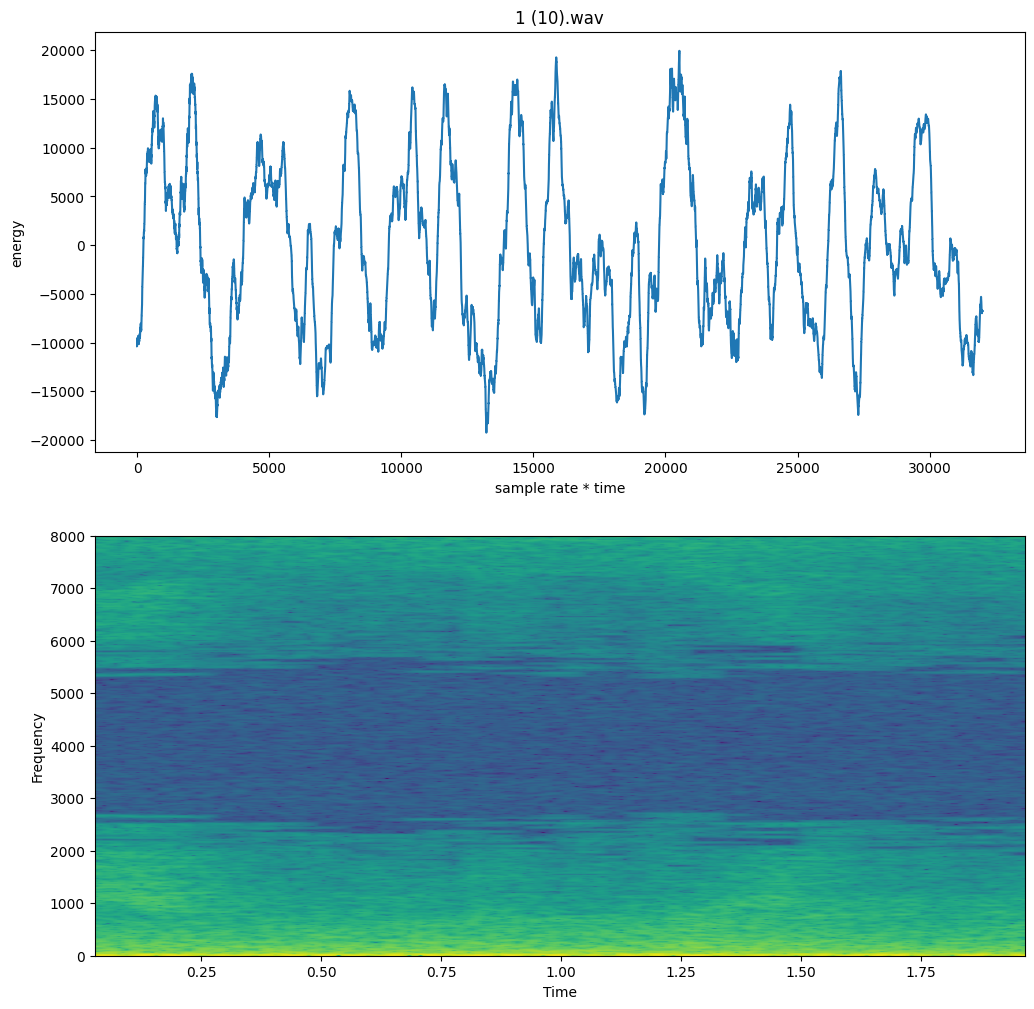

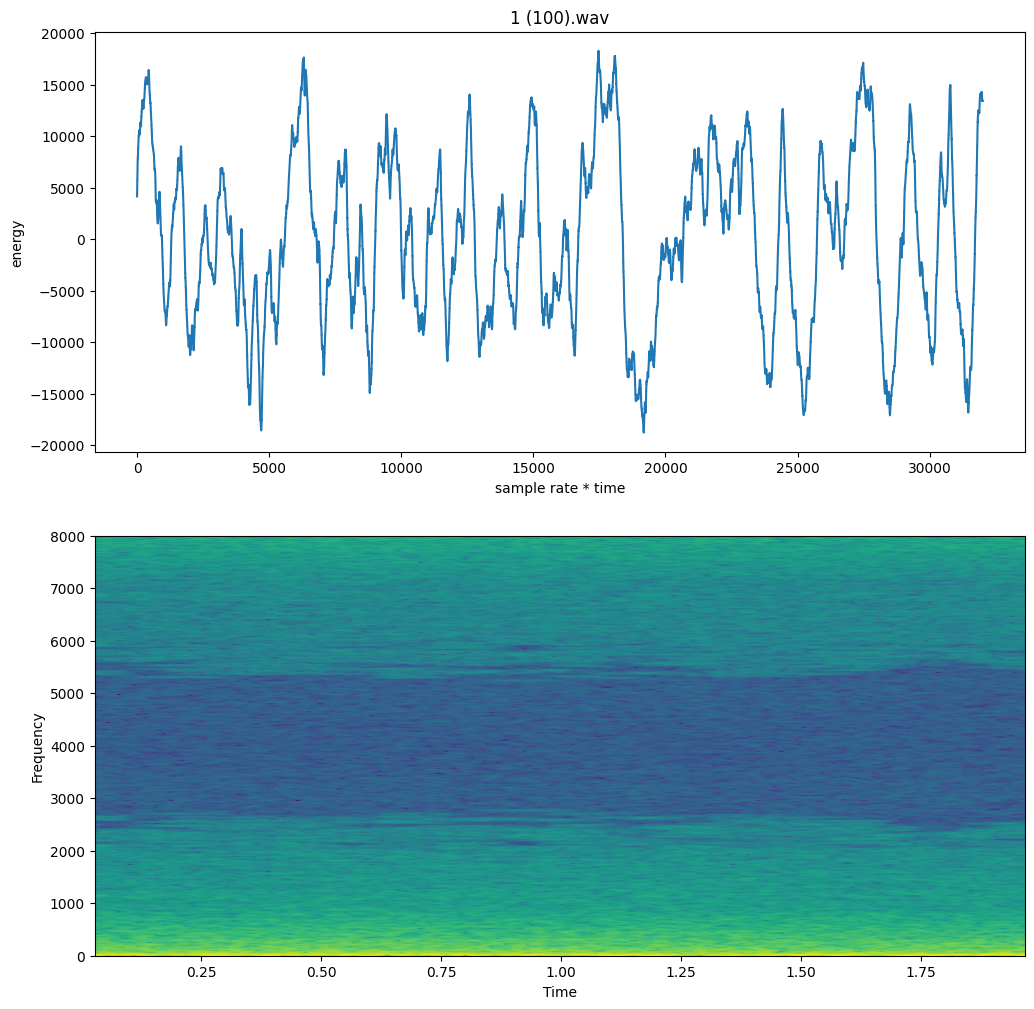

In [10]:
# Plot first 5 WAV files as a waveform and a frequency spectrum
for i in range(3): 
    signal_wave = wave.open(os.path.join(INPUT_DIR, parent_list[i]), 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

Sound to Image

In [11]:
# # Utility function to get sound and frame rate info
# def get_wav_info(wav_file):
#     wav = wave.open(wav_file, 'r')
#     frames = wav.readframes(-1)
#     sound_info = pylab.frombuffer(frames, 'int16')
#     frame_rate = wav.getframerate()
#     wav.close()
#     return sound_info, frame_rate

# # For every recording, make a spectogram and save it as label_speaker_no.png
# if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
#     os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    
# for filename in os.listdir(INPUT_DIR):
#     if "wav" in filename:
#         file_path = os.path.join(INPUT_DIR, filename)
#         file_stem = Path(file_path).stem
#         target_dir = f'class_{file_stem[0]}'
#         dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
#         file_dist_path = os.path.join(dist_dir, file_stem)
#         if not os.path.exists(file_dist_path + '.png'):
#             if not os.path.exists(dist_dir):
#                 os.mkdir(dist_dir)
#             file_stem = Path(file_path).stem
#             sound_info, frame_rate = get_wav_info(file_path)
#             pylab.specgram(sound_info, Fs=frame_rate)
#             pylab.savefig(f'{file_dist_path}.png')
#             pylab.close()

# # Print the ten classes in our dataset
# path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
# print("Classes: \n")
# for i in range(8):
#     print(path_list[i])

In [12]:
labels = ['Bus', 'Car (C Class - 4K)', 'Crossover', 'Jeep', 'Minibus', 'Pickup', 'Sports Car', 'Truck']
class_names_label = {class_name:i for i, class_name in enumerate(labels)}

nb_classes = len(labels)

Preprocessing

In [13]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            batch_size=BATCH_SIZE,
                                            validation_split=0.2,
                                            directory=os.path.join(OUTPUT_DIR, 'audio-images/train'),
                                            shuffle=True,
                                            color_mode='rgb',
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            subset="training",
                                            seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            batch_size=BATCH_SIZE,
                                            validation_split=0.2,
                                            directory=os.path.join(OUTPUT_DIR, 'audio-images/train'),
                                            shuffle=True,
                                            color_mode='rgb',
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            subset="validation",
                                            seed=0)

Found 4380 files belonging to 8 classes.
Using 3504 files for training.
Found 4380 files belonging to 8 classes.
Using 876 files for validation.


In [14]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

Model

In [122]:
model = tf.keras.applications.DenseNet201(
                                input_shape=(256,256,3),
                                include_top=False,weights='imagenet',pooling='avg')
model.trainable = False

In [123]:
inputs = model.input
x = tf.keras.layers.Dense(128, activation='relu')(model.output)
outputs = tf.keras.layers.Dense((8), activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [124]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [125]:
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
110/110 [==============================] - 58s 409ms/step - loss: 1.3989 - accuracy: 0.5026 - val_loss: 1.1478 - val_accuracy: 0.5434
Epoch 2/10
110/110 [==============================] - 41s 373ms/step - loss: 0.7998 - accuracy: 0.7309 - val_loss: 0.6313 - val_accuracy: 0.7945
Epoch 3/10
110/110 [==============================] - 42s 379ms/step - loss: 0.5622 - accuracy: 0.8211 - val_loss: 0.6347 - val_accuracy: 0.7203
Epoch 4/10
110/110 [==============================] - 42s 380ms/step - loss: 0.4365 - accuracy: 0.8610 - val_loss: 0.5392 - val_accuracy: 0.7842
Epoch 5/10
110/110 [==============================] - 42s 382ms/step - loss: 0.3419 - accuracy: 0.8936 - val_loss: 0.4185 - val_accuracy: 0.8459
Epoch 6/10
110/110 [==============================] - 43s 393ms/step - loss: 0.2806 - accuracy: 0.9118 - val_loss: 0.2732 - val_accuracy: 0.9189
Epoch 7/10
110/110 [==============================] - 43s 387ms/step - loss: 0.2279 - accuracy: 0.9295 - val_loss: 0.3250 - val_ac

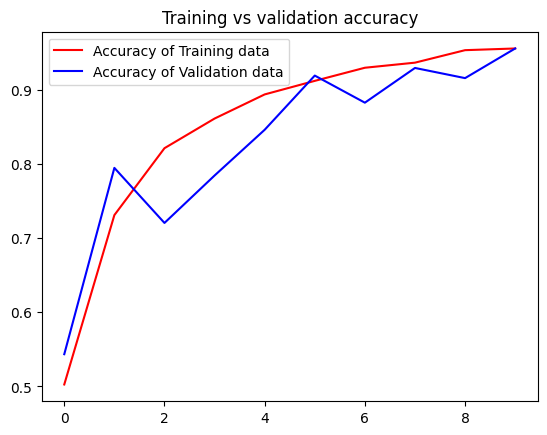

<Figure size 640x480 with 0 Axes>

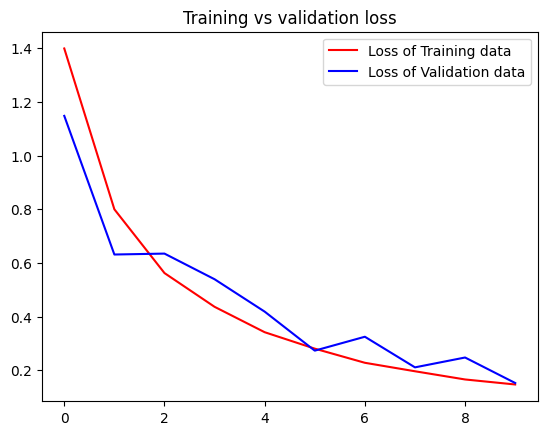

<Figure size 640x480 with 0 Axes>

In [126]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Train accuracy

In [127]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Train loss: {0:.6f}, Train accuracy: {1:.6f}".format(final_loss, final_acc))

Train loss: 0.152648, Train accuracy: 0.955479


Save Model

In [128]:
model.save("./models/DenseNet201.h5")

Test

In [15]:
import tensorflow as tf

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the validation spectrogram
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            batch_size=BATCH_SIZE,
                                            directory=os.path.join(OUTPUT_DIR, 'audio-images/test'),
                                            shuffle=True,
                                            color_mode='rgb',
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)

test_dataset = prepare(test_dataset, augment=False)

Found 1600 files belonging to 8 classes.


Test accuracy

In [16]:
from keras.models import load_model
# Declare constants
model =  load_model("./models/DenseNet201.h5")
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(test_dataset, verbose=0)
print("Test loss: {0:.6f}, Test accuracy: {1:.6f}".format(final_loss, final_acc))

Test loss: 0.315697, Test accuracy: 0.891875


Confusion Matrix

1/1 [==============================] - 0s 118ms/step
Accuracy: 0.891875


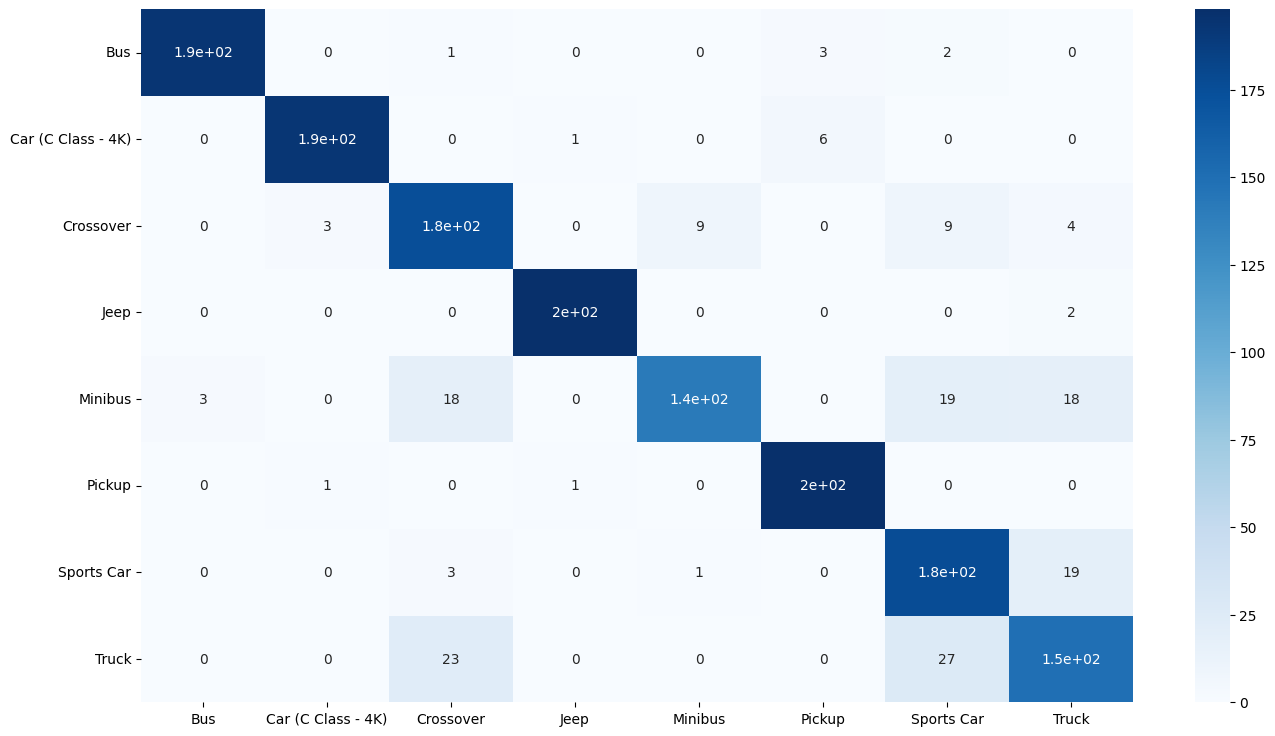

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset and compute predictions
for x, y in test_dataset:
    # Predict labels for the current batch
    preds = model.predict(x)
    
    # Convert predictions to class labels
    pred_labels.extend(np.argmax(preds, axis=1))
    
    # Append true labels
    true_labels.extend(y.numpy())  # Convert TensorFlow tensor to NumPy array
    
# Convert lists to numpy arrays for computation
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Compute accuracy
accuracy = np.mean(pred_labels == true_labels)
print('Accuracy:', accuracy)

# Compute confusion matrix
confusion_matr = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True,
            xticklabels=labels,
            yticklabels=labels)
plt.savefig("conf matrix")


Predict

1/1 [==============================] - 0s 75ms/step


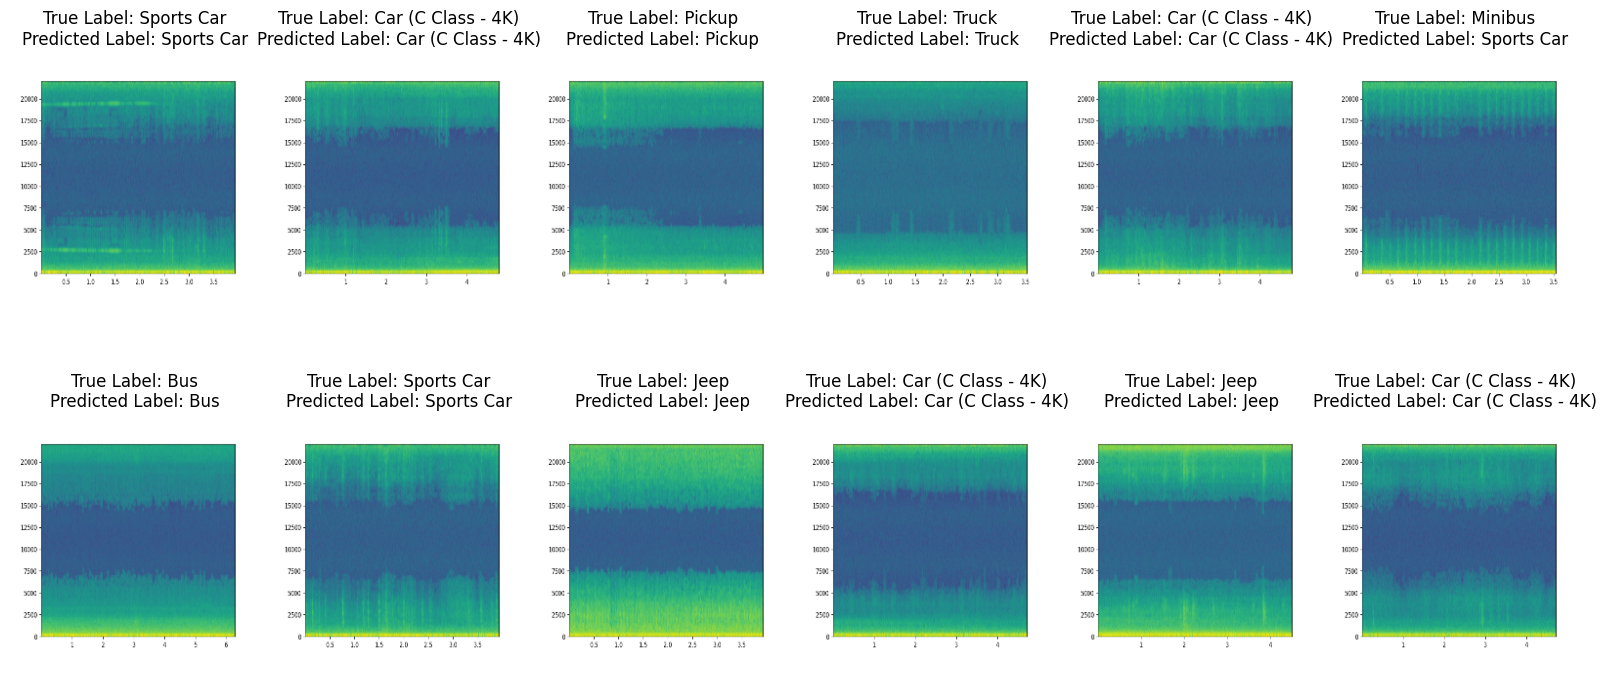

Accuracy: 0.9166666666666666


In [28]:
import random
import numpy as np

labels = ['Bus', 'Car (C Class - 4K)', 'Crossover', 'Jeep', 'Minibus', 'Pickup', 'Sports Car', 'Truck']

def get_label(prediction):
    return labels[prediction]

# Create a figure with 2 rows and 4 columns
plt.figure(figsize=(16, 8))

# Initialize variables to store true and predicted labels
true_labels = []
predicted_labels = []

# Get true and predicted labels for a random batch from the test dataset
for x, y in test_dataset.take(1):
    for i in range(min(len(x), 12)):  # Display up to 8 images
        # Get the image
        image = x[i].numpy()

        # Predict the label
        prediction = np.argmax(model.predict(image.reshape(-1, 256, 256, 3)))

        # Store true and predicted labels
        true_labels.append(y[i])  # y already contains the true labels
        predicted_labels.append(prediction)
        
        plt.subplot(2, 6, i + 1)
        plt.imshow(image)
        plt.title(f'True Label: {labels[y[i]]}\nPredicted Label: {get_label(prediction)}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate accuracy
accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
print("Accuracy:", accuracy)
